# Churn Analysis
The following analysis uses a scrubbed dataset based on a subscription platform. The objective of the analysis is to investigate churn and build a predictive model. The three tables included in the dataset are as follows:

- **Users**: A list of all active and inactive subscribers

- **Orders**: A list of all orders

- **Line items**: A list of all items in every order

The investigation is split into seven sections:

1. [Importing packages and files](#1)
2. [Examination of fields, shapes, and missing values](#2)
3. [Data cleaning and transformation](#3)
4. [Churn analysis and visualization](#4)
5. [Exploratory data analysis](#5)
6. [Feature engineering](#6)
7. [Final classification modeling](#7)

<a id='1'></a>
## 1. Import packages and data files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)

In [2]:
users = pd.read_csv('users.txt', sep='|')
orders = pd.read_csv('orders.txt', sep='|')
line_items = pd.read_csv('line_items.txt', sep='|')

/Users/charleszien/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<a id='2'></a>
## 2. Get a feel for the data

### 2.1 Print shapes and heads

In [3]:
print(users.shape)
users.head(2)

(88186, 13)


,user_number,created_at,original_sub_date,unsub_date,most_recent_sub,dob,dinghy,high_performance,sailing_frequency,active_subscriber,boat_class,number_of_crew,source_category
0,5555e59b17c05c24cc37c9220d5793a20d919fff76bf64...,7/18/2019 05:05:08.890461,2019-07-18 05:05:12.673728,7/26/2019 14:39:02.618144,7/18/2019 05:05:12.673712,NaN,f,f,2,f,global,3,facebook
1,c3b9d29fdbe854fb0172abf3bd90dd8b132e094a828d81...,6/1/2019 12:11:54.94819,2019-06-01 12:11:54.967822,10/4/2019 13:17:48.887805,6/1/2019 12:11:54.967799,NaN,f,f,2,f,global,3,dripleads


In [4]:
print(orders.shape)
orders.head(2)

(461112, 13)


,user_number,number,completed_at,order_category,ship_date,sailing_total,sailing_charged,rigging_total,rigging_charged,sailing_tax,rigging_tax,total_charged,state
0,0b6e82157ae3929598b1feee6244ba577ec35bb798ff80...,R204745000,2019-08-11 05:49:02.807307,club,8/12/2019,117.56,79.98,9.95,9.95,0.00,0.0,89.93,Massachusetts
1,ee98c9284e10492c120b6d97603ab04a39a9e56d814eea...,R643320908,2019-08-19 18:00:05.858210,intro,8/20/2019,123.88,29.95,9.95,0.00,2.65,0.0,32.60,New York


In [5]:
print(line_items.shape)
line_items.head(2)

(2683363, 4)


,number,product_id,category,quantity
0,R127717011,0,boat,1.0
1,R464303593,1,boat,6.0


### 2.2 Check data types and missing values
It looks like there are relatively few missing values - lucky for us!

In [6]:
print(users.info(), orders.info(), line_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88186 entries, 0 to 88185
Data columns (total 13 columns):
user_number          88186 non-null object
created_at           88186 non-null object
original_sub_date    88186 non-null object
unsub_date           54274 non-null object
most_recent_sub      88186 non-null object
dob                  1 non-null object
dinghy               88186 non-null object
high_performance     88186 non-null object
sailing_frequency    88186 non-null int64
active_subscriber    88186 non-null object
boat_class           88186 non-null object
number_of_crew       88186 non-null int64
source_category      84602 non-null object
dtypes: int64(2), object(11)
memory usage: 8.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461112 entries, 0 to 461111
Data columns (total 13 columns):
user_number        461104 non-null object
number             461112 non-null object
completed_at       461112 non-null object
order_category     461112 non-null object
ship_dat

<a id='3'></a>
## 3. Clean and transform
Time fields were read as strings, so they need to be converted to times for the analysis. A *tenure_days* column was also created.

In [7]:
users['created_at'] = pd.to_datetime(users['created_at'],
                                     format='%m/%d/%Y %H:%M:%S.%f')
users['unsub_date'] = pd.to_datetime(users['unsub_date'],
                                     format='%m/%d/%Y %H:%M:%S.%f')
users['most_recent_sub'] = pd.to_datetime(users['most_recent_sub'],
                                          format='%m/%d/%Y %H:%M:%S.%f')
users['original_sub_date'] = pd.to_datetime(users['original_sub_date'])
users['tenure_days'] = (users['unsub_date'] -
                        users['most_recent_sub']).dt.days + 1
users.loc[users['tenure_days'].isna(), 'tenure_days'] = (
    users['most_recent_sub'].max() - users['most_recent_sub']).dt.days + 1
users = users.drop(columns='dob', axis=1)
orders['completed_at'] = pd.to_datetime(orders['completed_at'])
orders['ship_date'] = pd.to_datetime(orders['ship_date'], format='%m/%d/%Y')

<a id='4'></a>
## 4. Build monthly and weekly churn models

To calculate churn, you first must know the total number of active users, which I calculated in the function below. I then constructed a dual-axis line plot to visualize the churn.

In [8]:
''' Generates a line plot of customer churn and subscriber base. Accepts a dataframe, period, and start date, draws plot and retuns table used to generate chart. '''


def churn_graph(df=users, period='W', period_start=pd.datetime(2018, 12, 12)):
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    if period == 'D':
        offset = pd.DateOffset(days=1)
        title = '30-Day Rolling Churn'
    elif period == 'W':
        offset = pd.DateOffset(weeks=1)
        title = 'Weekly Churn'
    else:
        offset = pd.DateOffset(months=1)
        title = 'Monthly Churn'

    # Generate dataframe and populate with unsubscribes by period
    a = pd.DataFrame(df.groupby(
        df['unsub_date'].dt.to_period(f'{period}')).size(),
        columns=['unsubscribes']).reset_index()
    a['unsub_date'] = [i.to_timestamp().date() for i in a['unsub_date']]
    a = a.loc[a['unsub_date'] >= period_start.date()]

    # Create a separate dataframe for each period to find active users
    active_list = []
    for i in range(len(a)):
        period_end = period_start + offset
        df['active'] = False
        df.loc[(df['most_recent_sub'] < period_start + offset) &
               ((df['unsub_date'] > period_end + offset) |
                (df['unsub_date'].isna())), 'active'] = True
        active_list.append(df['active'].sum())
        period_start = period_end
    a['active_users'] = active_list

    # Calculate churn
    a['churn'] = a['unsubscribes'] / a['active_users']

    # Generate rolling churn calculation for daily chart
    if period == 'D':
        a['churn'] = a['churn'].rolling(30, win_type='triang').mean()

    # Draw chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.lineplot(x="unsub_date", y="active_users", data=a, color='blue')
    ax.set_xlabel('Date')
    ax.set_ylabel('Active Users', color='blue')
    ax2 = ax.twinx().set_title(title)
    ax2 = sns.lineplot(x="unsub_date", y="churn", data=a, color='red')
    ax2.set_ylabel('Churn', color='red')
    return a

### 4.1 Monthly
Generally, when you hear about churn, it's on a monthly basis, so that's where I started: 

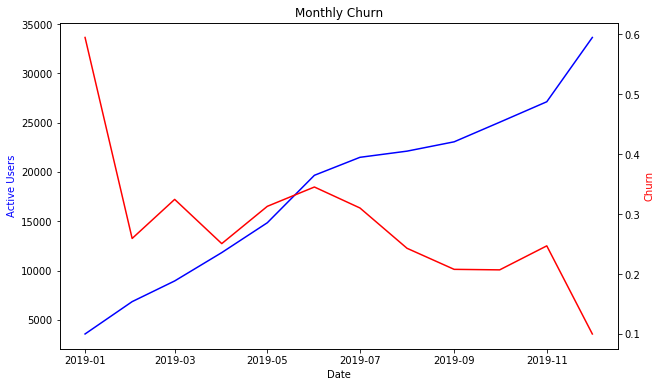

In [9]:
a = churn_graph(period='M')

### 4.2 Weekly
I noticed the monthly chart looked a bit, shall we say, "spiky," so I wanted to be sure I was capturing some of the finer nuances. I also modeled the churn on a weekly basis. The caveat here is that there can be a lot of fluctuation in weekly churn given the short time period. However, in both cases, churn is showing a downward trend.

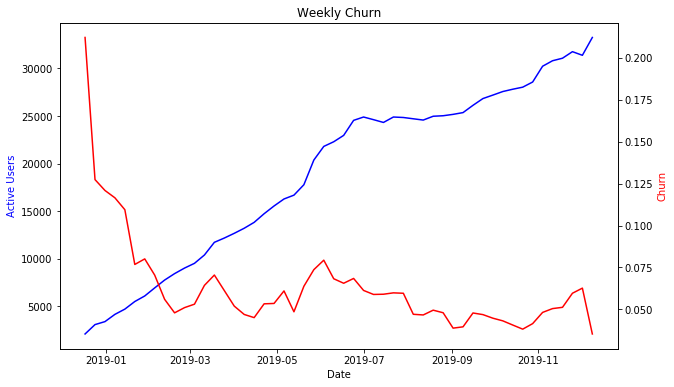

In [10]:
a = churn_graph()

### 4.3 Daily
A lot can change from week to week. Ever the perfectionist, I wanted to go a level deeper, so I constructed a 30-day rolling window to smooth things out a bit. This more or less mirrors the weekly chart, but because it's a rolling average, it is less responsive than the weekly chart — everything is shifted just a bit to the right! It's a good retrospective tool, but is less suited to real-time monitoring of performance metrics.

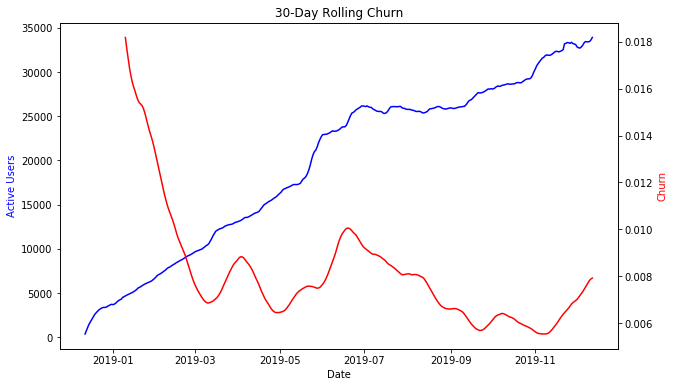

In [11]:
a = churn_graph(period='D')

<a id='5'></a>
## 5. Slice and dice

### 5.1 Gaming the system
I used the new *tenure_days* data to check the distribution of tenure on the platform. Interestingly, there were numerous same-day cancellations. My suspicion was that these users were gaming the system by signing up for the intro offer and cancelling immediately thereafter.

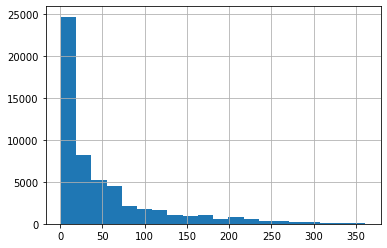

In [12]:
df = users.loc[users['active_subscriber'] == 'f']
df['tenure_days'].hist(bins=20)

To verify my hunch, I used the *orders* table to find each user's first order. Then, I built a bar plot to check whether the "fast churners" were taking advantage of the introductory offer more than the typical customer. This does appear to be the case!

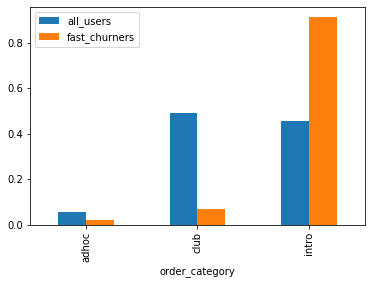

In [13]:
df = pd.merge(orders, users, on='user_number')

# This is a compute-intensive operation so I am running it on a small sample
first_order = df.sample(1000).groupby('user_number').min()[[
    'number', 'order_category', 'completed_at'
]]

first_order_categories = pd.DataFrame(
    first_order.groupby('order_category').size(), columns=['all_users'])

first_order_categories['fast_churners'] = df.loc[(
    df['tenure_days'] == 1), 'order_category'].groupby(
        df['order_category']).size()

first_order_categories['all_users'] = first_order_categories[
    'all_users'] / first_order_categories['all_users'].sum()
first_order_categories['fast_churners'] = first_order_categories[
    'fast_churners'] / first_order_categories['fast_churners'].sum()

first_order_categories.plot.bar()

### 5.2 It's the source, of course
It makes sense that users coming from different sources have different propensity to churn. For example, there would probably be much better odds of retention for an well-targeted ad on Facebook, while a more general source, such as mail, would bring in less loyal customers. This is indeed how it played out.

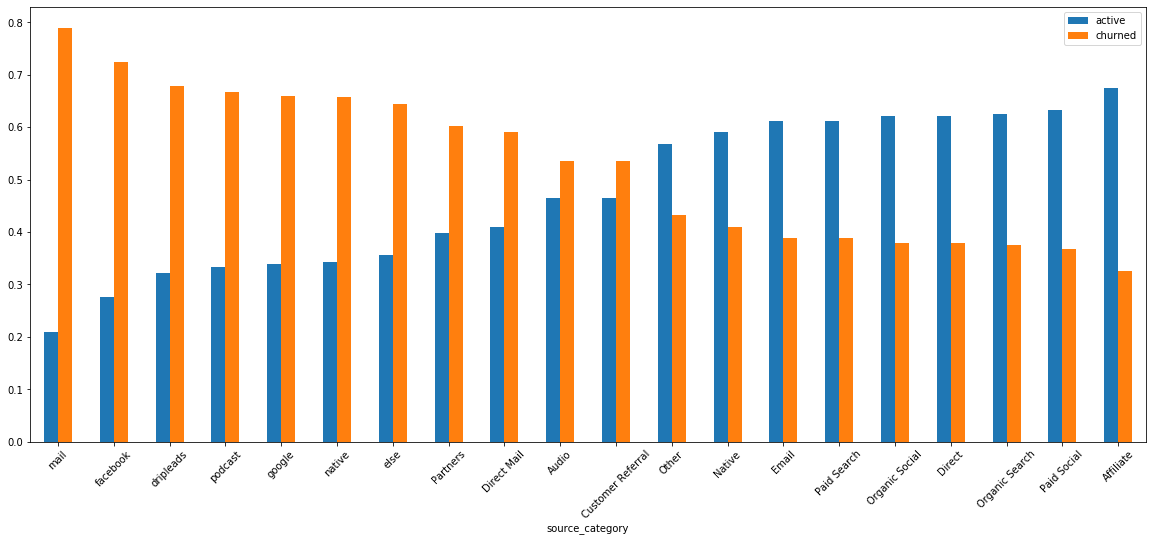

In [14]:
a = users.groupby('source_category').size()
a = pd.DataFrame(a.loc[a > 100])
b = (users.groupby(['source_category', 'active_subscriber']).size() /
     users.groupby('source_category').size()).unstack().sort_values(by='t')
a = pd.merge(b, a, on='source_category')[['t', 'f']]
a.columns = ['active', 'churned']

a.plot(kind='bar', figsize=(20, 8), rot=45)

<a id='6'></a>
## 6. Engineer features
The next step is to encode all features as numerics. In some cases (*dinghy* and *high_performance*), this is as simple as swapping in 0 and 1 for the values. Other columns required dummification.

I generated the labels based on the *active_subscriber* column, with 1 indicating a user has churned.

In [15]:
# Defining number of orders, mean order value
num_orders = df.groupby('user_number').size()
mean_order_value = df.groupby('user_number').mean()['total_charged']
tmp = pd.DataFrame(pd.concat((num_orders, mean_order_value), axis=1))
tmp.columns = ['num_orders', 'mean_order_value']
features = pd.merge(users, tmp, on='user_number')

# Binary encoding dinghy and high_performance
features['dinghy'] = features['dinghy'].replace('t', 1).replace('f', 0)
features['high_performance'] = features['high_performance'].replace(
    't', 1).replace('f', 0)

# Dropping 204 orders with no value
features = features[~features['mean_order_value'].isna()]

# Setting labels
labels = features['active_subscriber'].replace('t', 0).replace('f', 1)

# Binary encoding boat_class and source_category
features = pd.concat(
    (features,
     pd.get_dummies(features[['boat_class', 'source_category']],
                    drop_first=True)),
    axis=1)

# Binary encoding and merging line items
df = pd.merge(line_items,
              pd.merge(orders, users, on='user_number'),
              on='number')
product_ids = pd.get_dummies(df['product_id'], prefix='product')
tmp = pd.concat((df['user_number'], product_ids), axis=1)
tmp = pd.DataFrame(tmp.groupby('user_number').sum())
tmp.reset_index(inplace=True)
features = pd.merge(features, tmp, on='user_number')

# Dropping unused fields
features.drop([
    'user_number', 'active_subscriber', 'original_sub_date', 'unsub_date',
    'created_at', 'most_recent_sub', 'boat_class', 'source_category', 'active'
],
    axis=1,
    inplace=True)

<a id='7'></a>
## 7. Train, fit, and evaluate models

### 7.1 Logistic regression
Given this is a binomial classification problem, a logistic regression seemed like a good first step. Using default parameters, the model was 87% accurate — not bad! Source categories and products purchased played a significant role in the model, as shown by the weights.

In [16]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)


model = LogisticRegression()
result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

weights = pd.Series(model.coef_[0], index=X.columns.values)
print(
    weights.sort_values(ascending=False).head(15),
    weights.sort_values().head(15))

/Users/charleszien/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      8490
           1       0.90      0.90      0.90     13500

    accuracy                           0.87     21990
   macro avg       0.87      0.87      0.87     21990
weighted avg       0.87      0.87      0.87     21990

source_category_else          2.765825
source_category_mail          2.680134
source_category_facebook      2.594553
source_category_google        2.517233
source_category_dripleads     2.397284
source_category_native        2.376097
source_category_podcast       2.285723
source_category_brandamb      2.032169
source_category_Partners      1.696870
source_category_time          1.581678
source_category_dripd9        1.515896
product_253                   1.477088
source_category_sailingmag    1.466633
product_44                    1.324527
product_37                    1.116252
dtype: float64 product_223   -1.939553
product_224   -1.711608
product_251   -1.690158
p

### 7.2 Decision tree
Decision trees are another good option for many classification problems, so I tried that next. This ended up being 88% accurate — getting better!

In [17]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      8490
           1       0.91      0.90      0.90     13500

    accuracy                           0.88     21990
   macro avg       0.88      0.88      0.88     21990
weighted avg       0.88      0.88      0.88     21990



### 7.3 Random forest
Finally, I decided to try a Random Forest. This yielded the best results so far, with 91% accuracy!

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

/Users/charleszien/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.83      0.93      0.88      8490
           1       0.95      0.88      0.92     13500

    accuracy                           0.90     21990
   macro avg       0.89      0.91      0.90     21990
weighted avg       0.91      0.90      0.90     21990



### 7.4 Hyperparameter tuning
I used a randomized search to find the optimal hyperparameters. Ideally, I would want to test at least 100 configurations, but for the purposes of this demonstration, I will just do 10, as this is a highly compute-intensive operation.

In [19]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [20]:
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
  

In [21]:
params = rf_random.best_params_
params

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': False}

In [22]:
rf = RandomForestClassifier(**params)

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=80, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      8490
           1       0.96      0.90      0.93     13500

    accuracy                           0.92     21990
   macro avg       0.91      0.92      0.92     21990
weighted avg       0.92      0.92      0.92     21990



### 7. Feature importance
I built a horizontal bar plot to show feature importances in the Random Forest model. Three of the newly-engineered features — *tenure_days, mean_order_value,* and *num_orders* — came out on top. The other most important determinants were related to specific products purchased. Interestingly, the source categories did not make it top the top in this model.

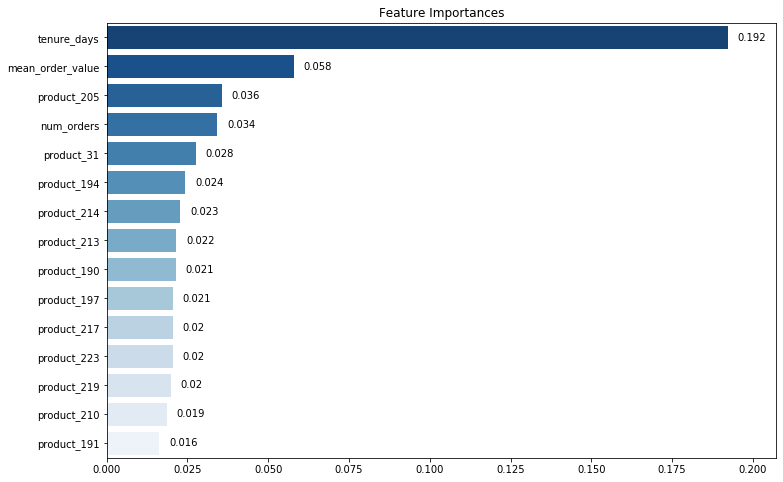

In [25]:
importance_dict = dict(zip(features, rf.feature_importances_))
importance_dict = {
    k: v
    for k, v in sorted(
        importance_dict.items(), key=lambda x: x[1], reverse=True)
}
tmp = list(importance_dict.items())[:15]
x = [i[0] for i in tmp]
y = [i[1] for i in tmp]

palette = 'Blues_r'
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(y, x, color='tab:blue', palette=palette)
ax.set(xlim=(0, max(y) + 0.015), title='Feature Importances')
total = len(y)
i = 0
for p in ax.patches:
    ax.text(p.get_width() + .003, p.get_y() + .5, s=round(y[i], 3), ha="left")
    i += 1